In [1]:
import os
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
frame=pd.read_csv('totaldataset.csv')

/opt/anaconda3/envs/data-x/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
def strpDateTime(data):
    return data['trx_timestamp'].apply(lambda x : datetime.strptime(x[:10]+x[11:19],"%Y-%m-%d%H:%M:%S"))
def dropCols(data):
    #d_memo and maybe block_num may have some relevance later on
    return data.drop(['account_action_seq','block_num','d_memo','authorization','global_action_seq','data','name','trx_id','trx_timestamp_unix'],axis=1)
def applyLabels(data):
    list_bots=['edgarwinston','Griffinhamza','jacksonjimmy','1ffyqhg4rmbk','1ffyqhg4rmbk','powellernest','2rezoaf4bhly','nckj42dit5sb','scottphillip','oepa252sdx4p','myh2o4wayvxg']
    list_humans=['g44dinjygene','onebrother11','rvrkingfishr','iloveyoudapp','huiyong12345','pketothemoon','zhshj1212123','vipgamedice2','dldldldldldl','pkeniubixxxx']
    data['bot_label']=data['d_from'].apply(lambda x: 1 if x in list_bots else (0 if x in list_humans else None))
def dataProcess(data):
    data['trx_timestamp']=strpDateTime(data)
    data['hours']=[i.hour for i in data['trx_timestamp']]
    data['minutes']=[i.minute for i in data['trx_timestamp']]
    data['seconds']=[i.second for i in data['trx_timestamp']]
    data['day']=[i.day for i in data['trx_timestamp']]
    applyLabels(data)
    return dropCols(data)

In [6]:
def timeseries_agg(data):
    '''
    Pulling together all data on an hourly basis and applying count_txns and volume_eos to it
    @params:
    data is the transaction data set
    
    
    '''
    hour_index=pd.date_range(start="3/1/2019", end="4/1/2019", freq="H")
    timeseries_dummy = pd.DataFrame(0, index=hour_index, columns=['count_txns', 'volume_eos'])
    timeseries_dummy=timeseries_dummy.astype(float)
    for index, row in data.iterrows(): 
        time=row['trx_timestamp'].replace(microsecond=0, second=0, minute=0)
        timeseries_dummy.loc[time]['count_txns']=1+timeseries_dummy.loc[time]['count_txns']
        timeseries_dummy.loc[time]['volume_eos']=row['d_quantity']+ timeseries_dummy.loc[time]['volume_eos']
    return timeseries_dummy
    

In [7]:
def maxAutoCorrelation(data,user):
    '''
    Returns a tuple with maxAutoCorrelation and lag period as values
    '''
    hold=0
    l=0
    data=timeseries_agg(data[data['d_from']==user])
    for i in range(1,168):
        check=data['count_txns'].autocorr(lag=i)
        if (check > hold):
            hold=check
            l=i
    return (hold,l)

In [8]:
def stdevVolumeSent(data,user):
    '''
    Returns a tuple with maxAutoCorrelation and lag period as values
    1-48 hour periods
    '''
    hold=0
    l=0
    data=data[data['Account']==user]
    return np.std(data['AmountDEX']['value'])

In [9]:
def countTotalTransactions(data,account_name):
    return data[data['d_from']==account_name].shape[0]

In [10]:
def getSubSetData(data,low,high):
    user_counts = data['d_from'].value_counts().rename('user_counts')

    zip_data_df = data.merge(user_counts.to_frame(),
                                left_on='d_from',
                                right_index=True)
    return zip_data_df[(zip_data_df['user_counts']>low) & (zip_data_df['user_counts']<high)]

In [11]:
def stdevVolumeSent(data,user):
    '''
    Returns a value of the standard deviation of volume of EOS sent
    '''
    hold=0
    l=0
    return np.std([x for x in data[data['d_from']==user]['d_quantity'].tolist()])

In [12]:
def accountAgg(data):
    list_accounts=data['d_from'].unique()
    dic={}
    dic={el:[0,0,0] for el in list_accounts}
    for key in dic.keys():
        dic[key][0]=maxAutoCorrelation(data,key)[0]
        dic[key][1]=countTotalTransactions(data,key)
        dic[key][2]=stdevVolumeSent(data,key)
    
    return pd.DataFrame.from_dict(dic,orient='index',columns=['maxAutoCorrelation','numberofTxns','stdevVolumeSent']).reset_index()
    

In [47]:
clean_frame=dataProcess(frame)

KeyboardInterrupt: 

In [48]:
data=accountAgg(getSubSetData(clean_frame,30,200))

In [51]:
data

,index,maxAutoCorrelation,numberofTxns,stdevVolumeSent
0,edgarwinston,0.983027,31,2.775558e-17
1,raidenkeegan,0.579704,41,3.864911e-01
2,heathderrick,0.983027,31,2.775558e-17
3,jakobantoine,0.983027,31,2.775558e-17
4,bryantjaylon,0.983027,31,2.775558e-17
...,...,...,...,...
1080,bobo12341234,0.335156,43,4.671004e-01
1081,bidream121cx,0.000000,42,1.453917e-01
1082,eosnicecoin3,0.342490,114,1.545759e+01
1083,ggu345srahdg,0.000000,66,1.019829e+01


In [16]:
data.to_csv('clusterdata.csv')

In [17]:
def getBotsViaAutoCorrThresh(data):
    names=[]
    for index,row in data.iterrows():
        if row['maxAutoCorrelation']>0.983026:
            names.append(row['index'])
    return names

In [18]:
def applyLabels2(data):
    list_bots=['edgarwinston','1ffyqhg4rmbk','nckj42dit5sb','heathderrick']
    list_bots=list_bots+getBotsViaAutoCorrThresh(data)
    list_humans=['nakajoneso33','myhappyended','bidream3idxx','h4nne5eos231','bobo12341234','praabc123abc']
    data['bot_label']=data['index'].apply(lambda x: 1 if x in list_bots else (0 if x in list_humans else None))

In [19]:
applyLabels2(data)

In [50]:
data

,index,maxAutoCorrelation,numberofTxns,stdevVolumeSent
0,edgarwinston,0.983027,31,2.775558e-17
1,raidenkeegan,0.579704,41,3.864911e-01
2,heathderrick,0.983027,31,2.775558e-17
3,jakobantoine,0.983027,31,2.775558e-17
4,bryantjaylon,0.983027,31,2.775558e-17
...,...,...,...,...
1080,bobo12341234,0.335156,43,4.671004e-01
1081,bidream121cx,0.000000,42,1.453917e-01
1082,eosnicecoin3,0.342490,114,1.545759e+01
1083,ggu345srahdg,0.000000,66,1.019829e+01


In [21]:
data['bot_label'].value_counts()

1.0    80
0.0     5
Name: bot_label, dtype: int64

In [2]:
data = pd.read_csv('clusteringDataSet1.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 19 columns):
Unnamed: 0                1085 non-null int64
index                     1085 non-null object
maxAutoCorrelation        1085 non-null float64
numberofTxns              1085 non-null int64
stDevEosSent              1085 non-null float64
numActiveDays             1085 non-null int64
maxTxnsDay                1085 non-null float64
minTxnsDay                1085 non-null float64
avgTxnsPerActiveDays      1085 non-null float64
numTxnsWeekdays           1085 non-null float64
numTxnsWeekends           1085 non-null float64
numActiveDaysWeekdays     1085 non-null int64
numActiveWeekends         1085 non-null int64
numActiveHours            1085 non-null int64
maxTxnsHour               1085 non-null float64
minTxnsHour               1085 non-null float64
txnsPerActiveHour         1085 non-null float64
numActiveHoursWeekdays    1085 non-null int64
numActiveHoursWeekends    1085 non-null int6

In [4]:
train = data
train

,Unnamed: 0,index,maxAutoCorrelation,numberofTxns,stDevEosSent,numActiveDays,maxTxnsDay,minTxnsDay,avgTxnsPerActiveDays,numTxnsWeekdays,numTxnsWeekends,numActiveDaysWeekdays,numActiveWeekends,numActiveHours,maxTxnsHour,minTxnsHour,txnsPerActiveHour,numActiveHoursWeekdays,numActiveHoursWeekends
0,0,edgarwinston,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
1,1,raidenkeegan,0.579704,41,3.864911e-01,31,11.0,0.0,1.322581,21.0,15.0,21,5,31,11.0,0.0,1.322581,21,5
2,2,heathderrick,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
3,3,jakobantoine,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
4,4,bryantjaylon,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,1080,bobo12341234,0.335156,43,4.671004e-01,1,43.0,0.0,43.000000,43.0,0.0,1,0,2,31.0,0.0,21.500000,2,0
1081,1081,bidream121cx,0.000000,42,1.453917e-01,1,42.0,0.0,42.000000,42.0,0.0,1,0,1,42.0,0.0,42.000000,1,0
1082,1082,eosnicecoin3,0.342490,114,1.545759e+01,1,114.0,0.0,114.000000,114.0,0.0,1,0,3,82.0,0.0,38.000000,3,0
1083,1083,ggu345srahdg,0.000000,66,1.019829e+01,1,66.0,0.0,66.000000,66.0,0.0,1,0,1,66.0,0.0,66.000000,1,0


## K-Means Clustering with 2 clusters


In [5]:
#bot or not
kmeans = KMeans(n_clusters=2)

In [6]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [7]:
X = np.array(train.drop(['index'], 1).astype(float))
#Y = np.array(train[])

In [9]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [10]:
Y=kmeans.predict(X)

### Clusters formed include 544-541 split.

In [11]:
[1085- sum(Y), sum(Y)]


[544, 541]

In [12]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Agglomerative Clustering

In [21]:
from sklearn.cluster import AgglomerativeClustering
ag=AgglomerativeClustering().fit(X)
pred = ag.fit_predict(X)

[sum(pred), 1085- sum(pred)]

[335, 750]

### 335-750 Split

In [24]:
#plt.scatter(X[ : , 0], X[ :, 1], s = 50)

In [25]:
#all the accounts with 0.983027 autocorrelation and 31 transactions are all bots

In [26]:
kmeans.cluster_centers_

array([[8.14000000e+02, 8.24814462e-01, 4.28890943e+01, 3.86392041e+00,
        2.55822551e+01, 1.31164510e+01, 0.00000000e+00, 8.56122065e+00,
        2.90609982e+01, 7.26802218e+00, 1.73308688e+01, 4.12754159e+00,
        2.69667283e+01, 9.70425139e+00, 0.00000000e+00, 5.78475570e+00,
        1.77670980e+01, 5.00924214e+00],
       [2.71500000e+02, 9.66559838e-01, 3.18786765e+01, 9.94060561e-04,
        3.09981618e+01, 1.86397059e+00, 0.00000000e+00, 1.02840568e+00,
        2.10147059e+01, 5.86397059e+00, 2.09981618e+01, 5.00000000e+00,
        3.18602941e+01, 1.01838235e+00, 0.00000000e+00, 1.00059298e+00,
        2.10147059e+01, 5.84558824e+00]])

## We use Robust Scaler to consider values within the InterQuartile Range

In [31]:

from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(X)

In [32]:
transformer.transform(X)

array([[-1.00000000e+00,  1.67340133e-02, -1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+00],
       [-9.98154982e-01, -3.86588689e-01,  9.00000000e+00, ...,
         3.22580645e-01,  0.00000000e+00, -1.00000000e+00],
       [-9.96309963e-01,  1.67340133e-02, -1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+00],
       ...,
       [ 9.96309963e-01, -6.23802520e-01,  8.20000000e+01, ...,
         3.70000000e+01, -1.80000000e+01, -6.00000000e+00],
       [ 9.98154982e-01, -9.66292660e-01,  3.40000000e+01, ...,
         6.50000000e+01, -2.00000000e+01, -6.00000000e+00],
       [ 1.00000000e+00, -7.81237035e-01,  5.00000000e+00, ...,
         1.75000000e+01, -1.90000000e+01, -6.00000000e+00]])

In [33]:
#Robust Scaler 

kmeans.fit(transformer.transform(X))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [35]:
sum(kmeans.predict(transformer.transform(X))), 1085 - sum(kmeans.predict(transformer.transform(X)))

(79, 1006)

## Principal Component Analysis

In [36]:
from sklearn.decomposition import PCA
    
pca = PCA(n_components=2).fit(X)
pca = pca.transform(X)

In [37]:
pca

array([[-541.77798546,   19.63865375],
       [-539.95313253,   33.15851981],
       [-539.78156515,   19.52035531],
       ...,
       [ 551.30856458,  174.68649946],
       [ 547.71570575,   93.22692194],
       [ 544.47896918,   20.36340185]])

## Calculation of the Silhouette Score to identify the optimal cluster count

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = list (range(2,10))
print ("Number of clusters from 2 to 9: \n", range_n_clusters)
scores = []


for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    scores.append(score)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
           

Number of clusters from 2 to 9: 
 [2, 3, 4, 5, 6, 7, 8, 9]
For n_clusters = 2, silhouette score is 0.6129696549268758)
For n_clusters = 3, silhouette score is 0.5656619063477487)
For n_clusters = 4, silhouette score is 0.536741925657471)
For n_clusters = 5, silhouette score is 0.5171765928102879)
For n_clusters = 6, silhouette score is 0.5287191372578344)
For n_clusters = 7, silhouette score is 0.5222686199013353)
For n_clusters = 8, silhouette score is 0.5273050005164966)
For n_clusters = 9, silhouette score is 0.5215656007879954)


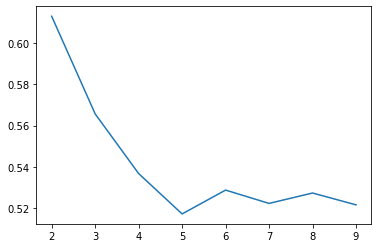

In [39]:
plt.plot(range(2,10), scores)

In [42]:
kmean3 = KMeans(n_clusters=5).fit(X)

In [43]:
pd.Series(kmean3.predict(X)).value_counts()

3    228
4    226
2    226
1    224
0    181
dtype: int64

## Gaussian Mixture Model 

In [50]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(X)

[1085 -155, sum(gmm.predict(X))]
 

[930, 112]

### 930-112 split

## Silhouette score calculation to find the optimal cluster count (elbow count) 

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = list (range(2,10))
print ("Number of clusters from 2 to 9: \n", range_n_clusters)
scores = []


for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters)
    preds = clusterer.fit_predict(X)

    score = silhouette_score(X, preds)
    scores.append(score)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

Number of clusters from 2 to 9: 
 [2, 3, 4, 5, 6, 7, 8, 9]
For n_clusters = 2, silhouette score is 0.35083133116223886)
For n_clusters = 3, silhouette score is 0.12410549237217018)
For n_clusters = 4, silhouette score is -0.0907187929591877)
For n_clusters = 5, silhouette score is -0.18331881647415513)
For n_clusters = 6, silhouette score is -0.29670269580599723)
For n_clusters = 7, silhouette score is -0.31056375280200915)
For n_clusters = 8, silhouette score is -0.3628987614113013)
For n_clusters = 9, silhouette score is -0.009576627340680937)


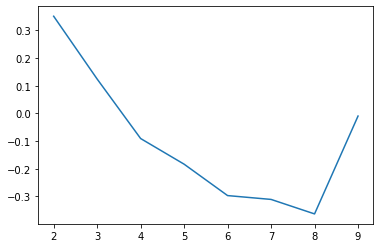

In [52]:
plt.plot(range(2,10),scores)